In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from scipy import stats

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def get_table_icd_helper(ser, comorbidity):
    table = [
        [ser[f"gene_{comorbidity}"], ser[f"gene_non{comorbidity}"]],
        [ser[f"nongene_{comorbidity}"], ser[f"nongene_non{comorbidity}"]]
    ]
    res = fisher_exact(table)
    or_study = odds_ratio(table)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    return pd.Series({"ID": ser.ID, "comorbidity": comorbidity, "OR": res.statistic, "p_value": res.pvalue, "ci_low": cil, "ci_high": cih})



In [3]:
aou_df = pd.read_csv("../data/icd_enrichment/monogenic_aou_comorbid.csv.gz", index_col=0)
ukb_df = pd.read_csv("../data/icd_enrichment/monogenic_ukb_comorbid.csv.gz", index_col=0)


In [4]:
meta_df = aou_df+ukb_df
meta_df = meta_df.reset_index()

In [ ]:
RERUN=False

if RERUN:
    df = pd.DataFrame()
    comorbidities = ["cvd", "cad", "ht", "t2d", "hf", "af", "pe", "vt", "avs", "grd", "cls", "ccs", "cd", "nfld", "koa" ] # "t1d","ob" 

    for comorbidity in comorbidities:
        cdf = meta_df.apply(get_table_icd_helper, axis=1, args=(comorbidity,))
        df = pd.concat((df, cdf))
        
    df.to_excel("../data/icd_enrichment/monogenic_comorbidities.xlsx")

In [6]:
icd_df = pd.read_excel("../data/icd_enrichment/monogenic_comorbidities.xlsx")
meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")

In [7]:
icd_df = icd_df.loc[icd_df.comorbidity.isin(["cvd", "cad", "ht", "t2d", "hf", "af", "pe", "vt", "avs", "grd", "cls", "ccs", "cd", "nfld", "koa"])]

In [8]:
plot_df = icd_df.loc[icd_df.ID.isin(icd_df.loc[icd_df.p_value<0.05, "ID"])]

In [9]:
or_df = plot_df.pivot(index=["ID"], columns=["comorbidity"], values=["OR"])
annot_df = plot_df.pivot(index=["ID"], columns=["comorbidity"], values=["p_value"])

In [10]:
meta_df["abs_beta"] = meta_df.beta.abs()

In [11]:
or_risk_df = or_df.loc[(meta_df.loc[(meta_df.ID.isin(or_df.index))&(meta_df.beta>1)].sort_values("abs_beta", ascending=False)["ID"])]
or_risk_df = or_risk_df.groupby(or_risk_df.index.str.split(".", expand=True).get_level_values(0)).agg("max")
or_risk_df = or_risk_df.loc[meta_df.loc[(meta_df.ID.isin(or_df.index))&(meta_df.beta>1)].groupby(meta_df.ID.str.split(".", expand=True).iloc[:, 0]).agg("max").sort_values("abs_beta", ascending=False).index]

In [12]:
or_protection_df = or_df.loc[(meta_df.loc[(meta_df.ID.isin(or_df.index))&(meta_df.beta<-1)].sort_values("abs_beta", ascending=False)["ID"])]
or_protection_df = or_protection_df.groupby(or_protection_df.index.str.split(".", expand=True).get_level_values(0)).agg("min")
or_protection_df = or_protection_df.loc[meta_df.loc[(meta_df.ID.isin(or_df.index))&(meta_df.beta<-1)].groupby(meta_df.ID.str.split(".", expand=True).iloc[:, 0]).agg("min").sort_values("abs_beta", ascending=False).index]

In [13]:
or_plot_df = pd.concat([or_risk_df, or_protection_df])

In [14]:
annot_df = annot_df.groupby(annot_df.index.str.split(".", expand=True).get_level_values(0)).agg("min")

In [15]:
annot_df = annot_df.loc[or_plot_df.index]

In [16]:
def get_star_values(value):
    star = ""
    if value<0.05:
        star = "*"
    if value<0.01:
        star = "**"
    if value<0.001:
        star="***"
    return star

annot_df = annot_df.applymap(lambda x: get_star_values(x))

In [17]:
row_color_dict = dict()

for idx in or_protection_df.index:
    row_color_dict[idx] = "green"

for idx in or_risk_df.index:
    row_color_dict[idx] = "red"

In [18]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [19]:
or_dict = {
    "af": "Atrial fibrillation", 
    "avs": "Aortic valve stenosis",
    "cad": "Coronary artery disease",
    "ccs": "Cholecystitis",
    "cd": "Crohn's disease",
    "cls": "Cholelithiasis",
    "cvd": "Cardiovascular disease",
    "grd": "Gastroesophageal reflux disease",
    "hf": "Heart failure",
    "ht": "Hypertension",
    "koa": "Knee osteoarthritis",
    "nfld": "Nonalcoholic fatty liver disease",
    "pe": "Pulmonary embolism ",
    "t2d": "Type 2 diabetes",
    "vt": "Venous thromboembolism",
    }

In [20]:
or_plot_df.columns = or_plot_df.columns.get_level_values(1).map(or_dict)

/Users/deeprobanerjee/miniconda3/envs/analysis/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


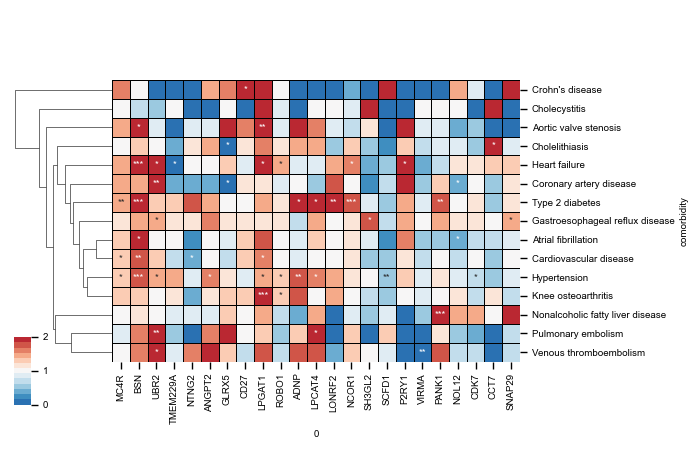

In [21]:
fig = sns.clustermap(
    or_plot_df.T, center=1, cmap=sns.color_palette("RdBu_r", 15)[1:-1], 
    square=True, vmin=0, vmax=2, linewidth=0.5, linecolor="k", col_cluster=False, 
    annot=annot_df.T, fmt="s", 
    figsize=(7, 4.5), cbar_pos=(0.02, 0.1, 0.025, 0.15)
    ) # row_colors=or_plot_df.index.map(row_color_dict)

In [22]:
save_pdf("../data/icd_enrichment/monogenic_comorbidities_v2.pdf", fig.figure)

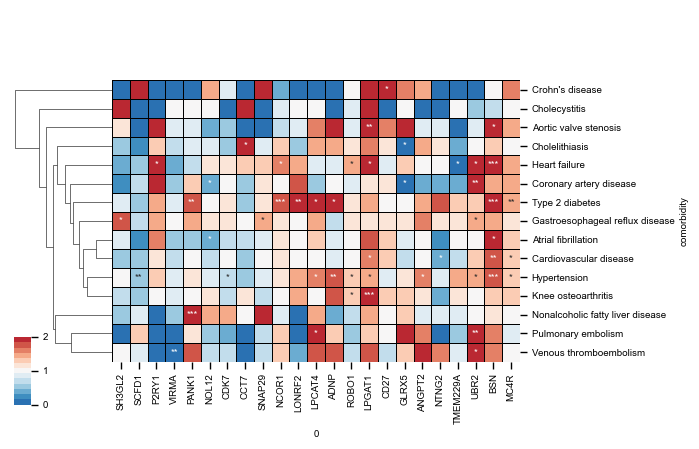

In [39]:
fig = sns.clustermap(
    or_plot_df.T, center=1, cmap=sns.color_palette("RdBu_r", 15)[1:-1], 
    square=True, vmin=0, vmax=2, linewidth=0.5, linecolor="k", col_cluster=False, 
    annot=annot_df.T, fmt="s", 
    figsize=(7, 4.5), cbar_pos=(0.02, 0.1, 0.025, 0.15)
    ) # row_colors=or_plot_df.index.map(row_color_dict)

In [40]:
save_pdf("../data/icd_enrichment/monogenic_comorbidities.pdf", fig.figure)

In [7]:
icd_df.loc[(icd_df.ID.isin(meta_df.loc[meta_df.beta>0, "ID"]))&(icd_df.p_value<0.05)]

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high
0,143,GADL1.PTV.0.001,t2d,1.860729,6.971829e-12,1.567225,2.198535
1,142,GADL1.PTV_Missense_strict.0.001,t2d,1.858477,7.210390e-12,1.565354,2.195833
22,155,WDR36.PTV_Missense_lenient.0.001,ob,1.923234,2.997646e-06,1.464795,2.496861
26,136,MAMDC4.PTV.0.001,t2d,1.231465,6.738888e-06,1.125238,1.345682
27,137,MAMDC4.PTV_Missense_strict.0.001,t2d,1.231465,6.738888e-06,1.125238,1.345682
...,...,...,...,...,...,...,...
483,183,NCOR1.PTV.0.001,hf,1.541434,4.908374e-02,0.964839,2.349126
484,184,NCOR1.PTV_Missense_strict.0.001,hf,1.541434,4.908374e-02,0.964839,2.349126
485,199,ROBO1.PTV.0.001,hf,1.517564,4.924620e-02,0.979738,2.255489
486,200,ROBO1.PTV_Missense_strict.0.001,hf,1.517564,4.924620e-02,0.979738,2.255489
